In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from time import time
import new_sampler as sampler
import old_sampler as sampler2
import numpy as np
import os
import copy

In [2]:
# Hyper Parameters 
input_size = 2
num_classes = 2
num_epochs = 3000
batch_size = 150
learning_rate = 0.1
max_sample_count = 1000
sub_sample_count = 150
active_dpp_batch_size = 40

In [3]:
data = torch.Tensor(np.load('data_synthetic/data3.npy'))
labels = torch.LongTensor(np.load('data_synthetic/labels3.npy'))

In [4]:
# DNN Model
class DNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DNN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, 4),
            nn.Sigmoid(),
            nn.Linear(4, num_classes)
        )
    
    def forward(self, x):
        out = self.classifier(x)
        return nn.functional.softmax(out, dim=1)

In [5]:
def train_and_test(train_imgs, train_lbls, test_imgs, test_lbls, verbose=True, batch_size=batch_size):
    model = DNN(input_size, num_classes)
    
    # Loss and train_labelsOptimizer
    # Softmax is internally computed.
    # Set parameters to be updated.
    criterion = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0) # weigth decay about 1e-3, 1e-4 is ok  

    # Training the Model
    for epoch in range(num_epochs):
        shuffle_ids = torch.randperm(train_lbls.shape[0])
        train_imgs = train_imgs[shuffle_ids]
        train_lbls = train_lbls[shuffle_ids]

        for i in range(train_lbls.shape[0] // batch_size):
            images = train_imgs[i*batch_size : (i+1)*batch_size]
            labels = train_lbls[i*batch_size : (i+1)*batch_size]

            images = Variable(images)
            labels = Variable(labels)

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if verbose and (i+1) % (train_lbls.shape[0] // batch_size) == 0:
                print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f' 
                       % (epoch+1, num_epochs, i+1, len(train_lbls)//batch_size, loss.item()))


    # Calculate training accuracy
    images = train_imgs[:]
    labels = train_lbls[:]

    images = Variable(images)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum()

    print('Accuracy of the model on the train images: %d %%' % (100 * correct / total))



    # Test the Model
    images = test_imgs[:]
    labels = test_lbls[:]

    images = Variable(images)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum()

    print('Accuracy of the model on the test images: %d %%' % (100 * correct / total))
    return model

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
def draw(points):
    plt.scatter([x for x, y in points], [y for x, y in points])
    plt.xlim(-3*np.pi, 3*np.pi)
    plt.ylim(-3*np.pi, 3*np.pi)
    plt.gca().set_aspect('equal')
    plt.pause(0.05)

In [9]:
# Full model (train = test)
model = train_and_test(data, labels, data, labels, verbose=False)

Accuracy of the model on the train images: 87 %
Accuracy of the model on the test images: 87 %


Accuracy of the model on the train images: 78 %
Accuracy of the model on the test images: 73 %


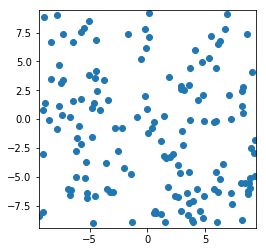

In [11]:
# Random subset model
sub_ids = torch.randperm(labels.shape[0])
train_ids = sub_ids[:sub_sample_count]
test_ids = sub_ids[sub_sample_count:]
model = train_and_test(data[train_ids], labels[train_ids], data[test_ids], labels[test_ids], verbose=False)
draw(data[train_ids].detach().numpy())

Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 83 %


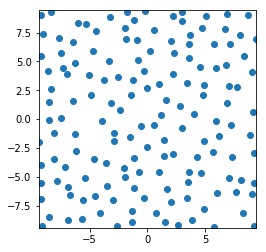

In [12]:
# Passive DPP subset model
train_ids = sampler.sample_ids_mc(data.numpy(), np.ones(labels.shape[0]), k=sub_sample_count, alpha=4., gamma=0.)

mask=np.full(labels.shape[0], True, dtype=bool)
mask[train_ids] = False
test_ids = np.arange(labels.shape[0])[mask]

model = train_and_test(data[train_ids], labels[train_ids], data[test_ids], labels[test_ids], verbose=False)

draw(data[train_ids].detach().numpy())

In [ ]:
# Active DPP subset model (new sampler)
scores = np.ones(labels.shape[0])
train_ids = []

batches = [60, 40, 20, 20, 20, 20, 20]

for i in range(len(batches)):
    new_train_ids = sampler.sample_ids_mc(data.numpy(), scores, k=batches[i], alpha=2., gamma=2., filename='temp.obj')
    train_ids = np.append(train_ids, new_train_ids).astype(np.int)
    os.remove("temp.obj")
    
    mask=np.full(labels.shape[0], True, dtype=bool)
    mask[train_ids] = False
    test_ids = np.arange(labels.shape[0])[mask]

    model = train_and_test(data[train_ids], labels[train_ids], data[test_ids], labels[test_ids], verbose=False, batch_size=len(train_ids))
    
    out = model(data[test_ids])
    out = out.detach().numpy()
    entropies = np.sum(-out*np.log(out),axis=1)
    
    scores = np.zeros_like(scores)
    scores[test_ids] = entropies
    
    draw(data[train_ids].detach().numpy())
    #import pdb; pdb.set_trace()

In [ ]:
# Active DPP subset model (old sampler w/ conditioning)
scores = np.ones(labels.shape[0])
train_ids = []

batches = [200]

for i in range(len(batches)):
    new_train_ids = sampler2.cond_sample_ids(data.numpy(), scores, cond_ids=train_ids, k=batches[i], gamma=0.)
    train_ids = np.append(train_ids, new_train_ids).astype(np.int)
    
    mask=np.full(labels.shape[0], True, dtype=bool)
    mask[train_ids] = False
    test_ids = np.arange(labels.shape[0])[mask]

    model = train_and_test(data[train_ids], labels[train_ids], data[test_ids], labels[test_ids], verbose=False, batch_size=len(train_ids))
    
    out = model(data)
    out = out.detach().numpy()
    scores = np.sum(-out*np.log(out),axis=1)
    
    draw(data[train_ids].detach().numpy())
    #import pdb; pdb.set_trace()

Accuracy of the model on the train images: 93 %
Accuracy of the model on the test images: 65 %
Accuracy of the model on the train images: 100 %
Accuracy of the model on the test images: 69 %
Accuracy of the model on the train images: 93 %
Accuracy of the model on the test images: 65 %
Accuracy of the model on the train images: 80 %
Accuracy of the model on the test images: 58 %
Accuracy of the model on the train images: 93 %
Accuracy of the model on the test images: 65 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 60 %
Accuracy of the model on the train images: 93 %
Accuracy of the model on the test images: 62 %
Accuracy of the model on the train images: 80 %
Accuracy of the model on the test images: 59 %
Accuracy of the model on the train images: 80 %
Accuracy of the model on the test images: 59 %
Accuracy of the model on the train images: 80 %
Accuracy of the model on the test images: 58 %
Accuracy of the model on the train images: 80 %
A

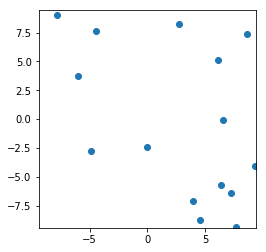

Accuracy of the model on the train images: 76 %
Accuracy of the model on the test images: 69 %
Accuracy of the model on the train images: 66 %
Accuracy of the model on the test images: 62 %
Accuracy of the model on the train images: 90 %
Accuracy of the model on the test images: 77 %
Accuracy of the model on the train images: 66 %
Accuracy of the model on the test images: 62 %
Accuracy of the model on the train images: 90 %
Accuracy of the model on the test images: 76 %
Accuracy of the model on the train images: 66 %
Accuracy of the model on the test images: 62 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 77 %
Accuracy of the model on the train images: 70 %
Accuracy of the model on the test images: 63 %
Accuracy of the model on the train images: 66 %
Accuracy of the model on the test images: 61 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 73 %
Accuracy of the model on the train images: 73 %
Ac

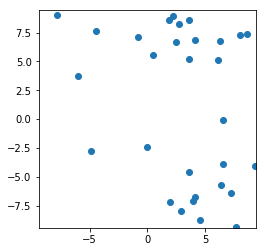

Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 81 %
Accuracy of the model on the train images: 84 %
Accuracy of the model on the test images: 78 %
Accuracy of the model on the train images: 93 %
Accuracy of the model on the test images: 81 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 88 %
Accuracy of the model on the test images: 79 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 88 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 88 %
Accuracy of the model on the test images: 80 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 81 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 80 %
Accuracy of the model on the train images: 88 %
Ac

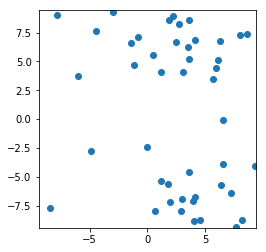

Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 90 %
Accuracy of the model on the test images: 78 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 71 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 65 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 82 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 88 %
Accuracy of the model on the test images: 76 %
Accuracy of the model on the train images: 78 %
Accuracy of the model on the test images: 76 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 74 %
Accuracy of the model on the train images: 91 %
Ac

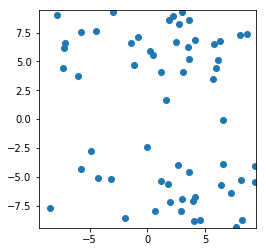

Accuracy of the model on the train images: 88 %
Accuracy of the model on the test images: 84 %
Accuracy of the model on the train images: 90 %
Accuracy of the model on the test images: 82 %
Accuracy of the model on the train images: 88 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 86 %
Accuracy of the model on the train images: 89 %
Accuracy of the model on the test images: 82 %
Accuracy of the model on the train images: 89 %
Accuracy of the model on the test images: 80 %
Accuracy of the model on the train images: 72 %
Accuracy of the model on the test images: 64 %
Accuracy of the model on the train images: 80 %
Accuracy of the model on the test images: 74 %
Accuracy of the model on the train images: 64 %
Accuracy of the model on the test images: 53 %
Accuracy of the model on the train images: 89 %
Accuracy of the model on the test images: 81 %
Accuracy of the model on the train images: 89 %
Ac

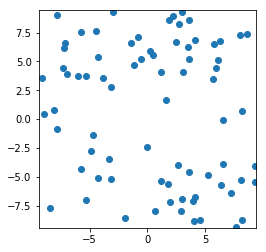

Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 88 %
Accuracy of the model on the test images: 84 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 84 %
Accuracy of the model on the train images: 90 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 74 %
Accuracy of the model on the test images: 60 %
Accuracy of the model on the train images: 87 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 84 %
Accuracy of the model on the train images: 84 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 88 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 91 %
Accuracy of the model on the test images: 86 %
Accuracy of the model on the train images: 84 %
Ac

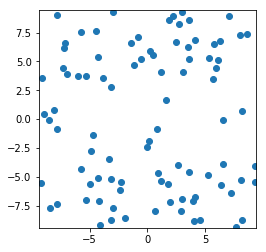

Accuracy of the model on the train images: 87 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 87 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 87 %
Accuracy of the model on the test images: 86 %
Accuracy of the model on the train images: 87 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 85 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 87 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 85 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 85 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 89 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 87 %
Accuracy of the model on the test images: 83 %
Accuracy of the model on the train images: 85 %
Ac

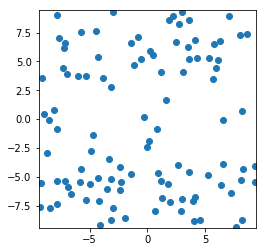

Accuracy of the model on the train images: 84 %
Accuracy of the model on the test images: 86 %
Accuracy of the model on the train images: 87 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 85 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 86 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 85 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 85 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 84 %
Accuracy of the model on the test images: 86 %
Accuracy of the model on the train images: 71 %
Accuracy of the model on the test images: 57 %
Accuracy of the model on the train images: 85 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 85 %
Ac

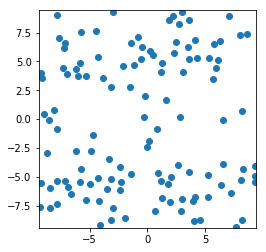

Accuracy of the model on the train images: 83 %
Accuracy of the model on the test images: 86 %
Accuracy of the model on the train images: 80 %
Accuracy of the model on the test images: 86 %
Accuracy of the model on the train images: 79 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 77 %
Accuracy of the model on the test images: 86 %
Accuracy of the model on the train images: 85 %
Accuracy of the model on the test images: 86 %
Accuracy of the model on the train images: 85 %
Accuracy of the model on the test images: 86 %
Accuracy of the model on the train images: 81 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 84 %
Accuracy of the model on the test images: 86 %
Accuracy of the model on the train images: 77 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 84 %
Accuracy of the model on the test images: 88 %
Accuracy of the model on the train images: 76 %
Ac

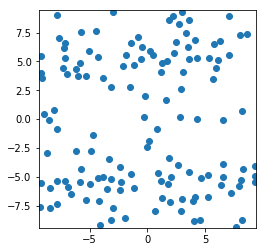

Accuracy of the model on the train images: 76 %
Accuracy of the model on the test images: 85 %
Accuracy of the model on the train images: 78 %
Accuracy of the model on the test images: 77 %
Accuracy of the model on the train images: 84 %
Accuracy of the model on the test images: 88 %
Accuracy of the model on the train images: 85 %
Accuracy of the model on the test images: 88 %
Accuracy of the model on the train images: 77 %
Accuracy of the model on the test images: 77 %
Accuracy of the model on the train images: 84 %
Accuracy of the model on the test images: 88 %
Accuracy of the model on the train images: 78 %
Accuracy of the model on the test images: 74 %
Accuracy of the model on the train images: 83 %
Accuracy of the model on the test images: 86 %
Accuracy of the model on the train images: 83 %
Accuracy of the model on the test images: 88 %
Accuracy of the model on the train images: 82 %
Accuracy of the model on the test images: 88 %
Accuracy of the model on the train images: 84 %
Ac

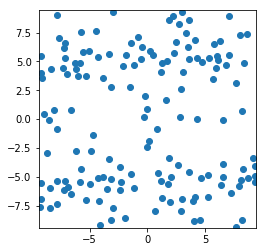

In [13]:
# Active DPP subset model (new sampler w/ conditioning)
scores = np.ones(labels.shape[0])
train_ids = []

batches = [15]*10

for i in range(len(batches)):
    k = int(np.ceil(2.0*batches[i]/3))
    #k = batches[i]
    new_train_ids = sampler.cond_sample_ids_mc(data.numpy(), scores, cond_ids=train_ids, k=k, alpha=4., gamma=5.)
    train_ids = np.append(train_ids, new_train_ids).astype(np.int)
    new_train_ids = sampler.cond_sample_ids_mc(data.numpy(), scores, cond_ids=train_ids, k=batches[i]-k, alpha=4., gamma=0.)
    train_ids = np.append(train_ids, new_train_ids).astype(np.int)
    
    mask=np.full(labels.shape[0], True, dtype=bool)
    mask[train_ids] = False
    test_ids = np.arange(labels.shape[0])[mask]

    
    out = np.zeros((20,data.shape[0],num_classes))
    models = []
    for j in range(20):
        models.append(train_and_test(data[train_ids], labels[train_ids], data[test_ids], labels[test_ids], verbose=False, batch_size=len(train_ids)))
        out[j,:,:] = models[j](data).detach().numpy()
    
    out = np.mean(out, axis=0)
    scores = np.sum(-out*np.log(out),axis=1)
    scores[scores!=scores] = 0 # because 0*log(0)=0
    scores = scores + 1e-8 # just to make sure condition is not zero-probability
    
    draw(data[train_ids].detach().numpy())
    #import pdb; pdb.set_trace()

In [14]:
model = train_and_test(data[train_ids], labels[train_ids], data[test_ids], labels[test_ids], verbose=True, batch_size=len(train_ids))

Epoch: [1/3000], Step: [1/1], Loss: 0.6923
Epoch: [2/3000], Step: [1/1], Loss: 0.6954
Epoch: [3/3000], Step: [1/1], Loss: 0.6873
Epoch: [4/3000], Step: [1/1], Loss: 0.6841
Epoch: [5/3000], Step: [1/1], Loss: 0.6848
Epoch: [6/3000], Step: [1/1], Loss: 0.6832
Epoch: [7/3000], Step: [1/1], Loss: 0.6804
Epoch: [8/3000], Step: [1/1], Loss: 0.6788
Epoch: [9/3000], Step: [1/1], Loss: 0.6783
Epoch: [10/3000], Step: [1/1], Loss: 0.6774
Epoch: [11/3000], Step: [1/1], Loss: 0.6756
Epoch: [12/3000], Step: [1/1], Loss: 0.6734
Epoch: [13/3000], Step: [1/1], Loss: 0.6722
Epoch: [14/3000], Step: [1/1], Loss: 0.6706
Epoch: [15/3000], Step: [1/1], Loss: 0.6689
Epoch: [16/3000], Step: [1/1], Loss: 0.6670
Epoch: [17/3000], Step: [1/1], Loss: 0.6646
Epoch: [18/3000], Step: [1/1], Loss: 0.6621
Epoch: [19/3000], Step: [1/1], Loss: 0.6599
Epoch: [20/3000], Step: [1/1], Loss: 0.6577
Epoch: [21/3000], Step: [1/1], Loss: 0.6555
Epoch: [22/3000], Step: [1/1], Loss: 0.6526
Epoch: [23/3000], Step: [1/1], Loss: 0.64

Epoch: [228/3000], Step: [1/1], Loss: 0.4849
Epoch: [229/3000], Step: [1/1], Loss: 0.4847
Epoch: [230/3000], Step: [1/1], Loss: 0.4844
Epoch: [231/3000], Step: [1/1], Loss: 0.4842
Epoch: [232/3000], Step: [1/1], Loss: 0.4841
Epoch: [233/3000], Step: [1/1], Loss: 0.4841
Epoch: [234/3000], Step: [1/1], Loss: 0.4842
Epoch: [235/3000], Step: [1/1], Loss: 0.4841
Epoch: [236/3000], Step: [1/1], Loss: 0.4840
Epoch: [237/3000], Step: [1/1], Loss: 0.4838
Epoch: [238/3000], Step: [1/1], Loss: 0.4836
Epoch: [239/3000], Step: [1/1], Loss: 0.4836
Epoch: [240/3000], Step: [1/1], Loss: 0.4835
Epoch: [241/3000], Step: [1/1], Loss: 0.4835
Epoch: [242/3000], Step: [1/1], Loss: 0.4835
Epoch: [243/3000], Step: [1/1], Loss: 0.4834
Epoch: [244/3000], Step: [1/1], Loss: 0.4832
Epoch: [245/3000], Step: [1/1], Loss: 0.4831
Epoch: [246/3000], Step: [1/1], Loss: 0.4830
Epoch: [247/3000], Step: [1/1], Loss: 0.4829
Epoch: [248/3000], Step: [1/1], Loss: 0.4829
Epoch: [249/3000], Step: [1/1], Loss: 0.4828
Epoch: [25

Epoch: [459/3000], Step: [1/1], Loss: 0.4740
Epoch: [460/3000], Step: [1/1], Loss: 0.4740
Epoch: [461/3000], Step: [1/1], Loss: 0.4740
Epoch: [462/3000], Step: [1/1], Loss: 0.4740
Epoch: [463/3000], Step: [1/1], Loss: 0.4740
Epoch: [464/3000], Step: [1/1], Loss: 0.4740
Epoch: [465/3000], Step: [1/1], Loss: 0.4740
Epoch: [466/3000], Step: [1/1], Loss: 0.4740
Epoch: [467/3000], Step: [1/1], Loss: 0.4741
Epoch: [468/3000], Step: [1/1], Loss: 0.4741
Epoch: [469/3000], Step: [1/1], Loss: 0.4742
Epoch: [470/3000], Step: [1/1], Loss: 0.4742
Epoch: [471/3000], Step: [1/1], Loss: 0.4742
Epoch: [472/3000], Step: [1/1], Loss: 0.4741
Epoch: [473/3000], Step: [1/1], Loss: 0.4741
Epoch: [474/3000], Step: [1/1], Loss: 0.4739
Epoch: [475/3000], Step: [1/1], Loss: 0.4738
Epoch: [476/3000], Step: [1/1], Loss: 0.4737
Epoch: [477/3000], Step: [1/1], Loss: 0.4737
Epoch: [478/3000], Step: [1/1], Loss: 0.4736
Epoch: [479/3000], Step: [1/1], Loss: 0.4736
Epoch: [480/3000], Step: [1/1], Loss: 0.4736
Epoch: [48

Epoch: [690/3000], Step: [1/1], Loss: 0.4703
Epoch: [691/3000], Step: [1/1], Loss: 0.4703
Epoch: [692/3000], Step: [1/1], Loss: 0.4704
Epoch: [693/3000], Step: [1/1], Loss: 0.4705
Epoch: [694/3000], Step: [1/1], Loss: 0.4707
Epoch: [695/3000], Step: [1/1], Loss: 0.4708
Epoch: [696/3000], Step: [1/1], Loss: 0.4710
Epoch: [697/3000], Step: [1/1], Loss: 0.4709
Epoch: [698/3000], Step: [1/1], Loss: 0.4709
Epoch: [699/3000], Step: [1/1], Loss: 0.4706
Epoch: [700/3000], Step: [1/1], Loss: 0.4705
Epoch: [701/3000], Step: [1/1], Loss: 0.4703
Epoch: [702/3000], Step: [1/1], Loss: 0.4702
Epoch: [703/3000], Step: [1/1], Loss: 0.4701
Epoch: [704/3000], Step: [1/1], Loss: 0.4701
Epoch: [705/3000], Step: [1/1], Loss: 0.4701
Epoch: [706/3000], Step: [1/1], Loss: 0.4701
Epoch: [707/3000], Step: [1/1], Loss: 0.4701
Epoch: [708/3000], Step: [1/1], Loss: 0.4701
Epoch: [709/3000], Step: [1/1], Loss: 0.4700
Epoch: [710/3000], Step: [1/1], Loss: 0.4700
Epoch: [711/3000], Step: [1/1], Loss: 0.4700
Epoch: [71

Epoch: [923/3000], Step: [1/1], Loss: 0.4685
Epoch: [924/3000], Step: [1/1], Loss: 0.4687
Epoch: [925/3000], Step: [1/1], Loss: 0.4687
Epoch: [926/3000], Step: [1/1], Loss: 0.4688
Epoch: [927/3000], Step: [1/1], Loss: 0.4687
Epoch: [928/3000], Step: [1/1], Loss: 0.4687
Epoch: [929/3000], Step: [1/1], Loss: 0.4685
Epoch: [930/3000], Step: [1/1], Loss: 0.4684
Epoch: [931/3000], Step: [1/1], Loss: 0.4683
Epoch: [932/3000], Step: [1/1], Loss: 0.4682
Epoch: [933/3000], Step: [1/1], Loss: 0.4681
Epoch: [934/3000], Step: [1/1], Loss: 0.4681
Epoch: [935/3000], Step: [1/1], Loss: 0.4680
Epoch: [936/3000], Step: [1/1], Loss: 0.4680
Epoch: [937/3000], Step: [1/1], Loss: 0.4680
Epoch: [938/3000], Step: [1/1], Loss: 0.4680
Epoch: [939/3000], Step: [1/1], Loss: 0.4680
Epoch: [940/3000], Step: [1/1], Loss: 0.4680
Epoch: [941/3000], Step: [1/1], Loss: 0.4680
Epoch: [942/3000], Step: [1/1], Loss: 0.4680
Epoch: [943/3000], Step: [1/1], Loss: 0.4679
Epoch: [944/3000], Step: [1/1], Loss: 0.4679
Epoch: [94

Epoch: [1154/3000], Step: [1/1], Loss: 0.4677
Epoch: [1155/3000], Step: [1/1], Loss: 0.4678
Epoch: [1156/3000], Step: [1/1], Loss: 0.4675
Epoch: [1157/3000], Step: [1/1], Loss: 0.4672
Epoch: [1158/3000], Step: [1/1], Loss: 0.4670
Epoch: [1159/3000], Step: [1/1], Loss: 0.4668
Epoch: [1160/3000], Step: [1/1], Loss: 0.4667
Epoch: [1161/3000], Step: [1/1], Loss: 0.4666
Epoch: [1162/3000], Step: [1/1], Loss: 0.4666
Epoch: [1163/3000], Step: [1/1], Loss: 0.4666
Epoch: [1164/3000], Step: [1/1], Loss: 0.4667
Epoch: [1165/3000], Step: [1/1], Loss: 0.4668
Epoch: [1166/3000], Step: [1/1], Loss: 0.4669
Epoch: [1167/3000], Step: [1/1], Loss: 0.4669
Epoch: [1168/3000], Step: [1/1], Loss: 0.4670
Epoch: [1169/3000], Step: [1/1], Loss: 0.4670
Epoch: [1170/3000], Step: [1/1], Loss: 0.4670
Epoch: [1171/3000], Step: [1/1], Loss: 0.4669
Epoch: [1172/3000], Step: [1/1], Loss: 0.4669
Epoch: [1173/3000], Step: [1/1], Loss: 0.4668
Epoch: [1174/3000], Step: [1/1], Loss: 0.4668
Epoch: [1175/3000], Step: [1/1], L

Epoch: [1376/3000], Step: [1/1], Loss: 0.4659
Epoch: [1377/3000], Step: [1/1], Loss: 0.4662
Epoch: [1378/3000], Step: [1/1], Loss: 0.4665
Epoch: [1379/3000], Step: [1/1], Loss: 0.4671
Epoch: [1380/3000], Step: [1/1], Loss: 0.4674
Epoch: [1381/3000], Step: [1/1], Loss: 0.4681
Epoch: [1382/3000], Step: [1/1], Loss: 0.4672
Epoch: [1383/3000], Step: [1/1], Loss: 0.4666
Epoch: [1384/3000], Step: [1/1], Loss: 0.4660
Epoch: [1385/3000], Step: [1/1], Loss: 0.4657
Epoch: [1386/3000], Step: [1/1], Loss: 0.4656
Epoch: [1387/3000], Step: [1/1], Loss: 0.4657
Epoch: [1388/3000], Step: [1/1], Loss: 0.4659
Epoch: [1389/3000], Step: [1/1], Loss: 0.4661
Epoch: [1390/3000], Step: [1/1], Loss: 0.4662
Epoch: [1391/3000], Step: [1/1], Loss: 0.4662
Epoch: [1392/3000], Step: [1/1], Loss: 0.4660
Epoch: [1393/3000], Step: [1/1], Loss: 0.4658
Epoch: [1394/3000], Step: [1/1], Loss: 0.4656
Epoch: [1395/3000], Step: [1/1], Loss: 0.4655
Epoch: [1396/3000], Step: [1/1], Loss: 0.4656
Epoch: [1397/3000], Step: [1/1], L

Epoch: [1604/3000], Step: [1/1], Loss: 0.4647
Epoch: [1605/3000], Step: [1/1], Loss: 0.4648
Epoch: [1606/3000], Step: [1/1], Loss: 0.4648
Epoch: [1607/3000], Step: [1/1], Loss: 0.4648
Epoch: [1608/3000], Step: [1/1], Loss: 0.4648
Epoch: [1609/3000], Step: [1/1], Loss: 0.4648
Epoch: [1610/3000], Step: [1/1], Loss: 0.4648
Epoch: [1611/3000], Step: [1/1], Loss: 0.4648
Epoch: [1612/3000], Step: [1/1], Loss: 0.4648
Epoch: [1613/3000], Step: [1/1], Loss: 0.4648
Epoch: [1614/3000], Step: [1/1], Loss: 0.4648
Epoch: [1615/3000], Step: [1/1], Loss: 0.4647
Epoch: [1616/3000], Step: [1/1], Loss: 0.4647
Epoch: [1617/3000], Step: [1/1], Loss: 0.4647
Epoch: [1618/3000], Step: [1/1], Loss: 0.4647
Epoch: [1619/3000], Step: [1/1], Loss: 0.4647
Epoch: [1620/3000], Step: [1/1], Loss: 0.4647
Epoch: [1621/3000], Step: [1/1], Loss: 0.4647
Epoch: [1622/3000], Step: [1/1], Loss: 0.4647
Epoch: [1623/3000], Step: [1/1], Loss: 0.4647
Epoch: [1624/3000], Step: [1/1], Loss: 0.4647
Epoch: [1625/3000], Step: [1/1], L

Epoch: [1831/3000], Step: [1/1], Loss: 0.4640
Epoch: [1832/3000], Step: [1/1], Loss: 0.4640
Epoch: [1833/3000], Step: [1/1], Loss: 0.4640
Epoch: [1834/3000], Step: [1/1], Loss: 0.4640
Epoch: [1835/3000], Step: [1/1], Loss: 0.4640
Epoch: [1836/3000], Step: [1/1], Loss: 0.4640
Epoch: [1837/3000], Step: [1/1], Loss: 0.4640
Epoch: [1838/3000], Step: [1/1], Loss: 0.4640
Epoch: [1839/3000], Step: [1/1], Loss: 0.4640
Epoch: [1840/3000], Step: [1/1], Loss: 0.4640
Epoch: [1841/3000], Step: [1/1], Loss: 0.4640
Epoch: [1842/3000], Step: [1/1], Loss: 0.4640
Epoch: [1843/3000], Step: [1/1], Loss: 0.4640
Epoch: [1844/3000], Step: [1/1], Loss: 0.4640
Epoch: [1845/3000], Step: [1/1], Loss: 0.4640
Epoch: [1846/3000], Step: [1/1], Loss: 0.4640
Epoch: [1847/3000], Step: [1/1], Loss: 0.4640
Epoch: [1848/3000], Step: [1/1], Loss: 0.4640
Epoch: [1849/3000], Step: [1/1], Loss: 0.4640
Epoch: [1850/3000], Step: [1/1], Loss: 0.4640
Epoch: [1851/3000], Step: [1/1], Loss: 0.4640
Epoch: [1852/3000], Step: [1/1], L

Epoch: [2058/3000], Step: [1/1], Loss: 0.4767
Epoch: [2059/3000], Step: [1/1], Loss: 0.4767
Epoch: [2060/3000], Step: [1/1], Loss: 0.4767
Epoch: [2061/3000], Step: [1/1], Loss: 0.4767
Epoch: [2062/3000], Step: [1/1], Loss: 0.4767
Epoch: [2063/3000], Step: [1/1], Loss: 0.4767
Epoch: [2064/3000], Step: [1/1], Loss: 0.4767
Epoch: [2065/3000], Step: [1/1], Loss: 0.4767
Epoch: [2066/3000], Step: [1/1], Loss: 0.4767
Epoch: [2067/3000], Step: [1/1], Loss: 0.4767
Epoch: [2068/3000], Step: [1/1], Loss: 0.4767
Epoch: [2069/3000], Step: [1/1], Loss: 0.4767
Epoch: [2070/3000], Step: [1/1], Loss: 0.4767
Epoch: [2071/3000], Step: [1/1], Loss: 0.4767
Epoch: [2072/3000], Step: [1/1], Loss: 0.4767
Epoch: [2073/3000], Step: [1/1], Loss: 0.4767
Epoch: [2074/3000], Step: [1/1], Loss: 0.4767
Epoch: [2075/3000], Step: [1/1], Loss: 0.4767
Epoch: [2076/3000], Step: [1/1], Loss: 0.4767
Epoch: [2077/3000], Step: [1/1], Loss: 0.4767
Epoch: [2078/3000], Step: [1/1], Loss: 0.4766
Epoch: [2079/3000], Step: [1/1], L

Epoch: [2290/3000], Step: [1/1], Loss: 0.4761
Epoch: [2291/3000], Step: [1/1], Loss: 0.4761
Epoch: [2292/3000], Step: [1/1], Loss: 0.4761
Epoch: [2293/3000], Step: [1/1], Loss: 0.4761
Epoch: [2294/3000], Step: [1/1], Loss: 0.4761
Epoch: [2295/3000], Step: [1/1], Loss: 0.4761
Epoch: [2296/3000], Step: [1/1], Loss: 0.4761
Epoch: [2297/3000], Step: [1/1], Loss: 0.4761
Epoch: [2298/3000], Step: [1/1], Loss: 0.4761
Epoch: [2299/3000], Step: [1/1], Loss: 0.4761
Epoch: [2300/3000], Step: [1/1], Loss: 0.4761
Epoch: [2301/3000], Step: [1/1], Loss: 0.4761
Epoch: [2302/3000], Step: [1/1], Loss: 0.4762
Epoch: [2303/3000], Step: [1/1], Loss: 0.4762
Epoch: [2304/3000], Step: [1/1], Loss: 0.4762
Epoch: [2305/3000], Step: [1/1], Loss: 0.4763
Epoch: [2306/3000], Step: [1/1], Loss: 0.4764
Epoch: [2307/3000], Step: [1/1], Loss: 0.4764
Epoch: [2308/3000], Step: [1/1], Loss: 0.4765
Epoch: [2309/3000], Step: [1/1], Loss: 0.4765
Epoch: [2310/3000], Step: [1/1], Loss: 0.4765
Epoch: [2311/3000], Step: [1/1], L

Epoch: [2522/3000], Step: [1/1], Loss: 0.4757
Epoch: [2523/3000], Step: [1/1], Loss: 0.4757
Epoch: [2524/3000], Step: [1/1], Loss: 0.4758
Epoch: [2525/3000], Step: [1/1], Loss: 0.4758
Epoch: [2526/3000], Step: [1/1], Loss: 0.4759
Epoch: [2527/3000], Step: [1/1], Loss: 0.4760
Epoch: [2528/3000], Step: [1/1], Loss: 0.4760
Epoch: [2529/3000], Step: [1/1], Loss: 0.4760
Epoch: [2530/3000], Step: [1/1], Loss: 0.4759
Epoch: [2531/3000], Step: [1/1], Loss: 0.4758
Epoch: [2532/3000], Step: [1/1], Loss: 0.4758
Epoch: [2533/3000], Step: [1/1], Loss: 0.4757
Epoch: [2534/3000], Step: [1/1], Loss: 0.4757
Epoch: [2535/3000], Step: [1/1], Loss: 0.4757
Epoch: [2536/3000], Step: [1/1], Loss: 0.4757
Epoch: [2537/3000], Step: [1/1], Loss: 0.4756
Epoch: [2538/3000], Step: [1/1], Loss: 0.4756
Epoch: [2539/3000], Step: [1/1], Loss: 0.4756
Epoch: [2540/3000], Step: [1/1], Loss: 0.4756
Epoch: [2541/3000], Step: [1/1], Loss: 0.4756
Epoch: [2542/3000], Step: [1/1], Loss: 0.4756
Epoch: [2543/3000], Step: [1/1], L

Epoch: [2753/3000], Step: [1/1], Loss: 0.4753
Epoch: [2754/3000], Step: [1/1], Loss: 0.4753
Epoch: [2755/3000], Step: [1/1], Loss: 0.4753
Epoch: [2756/3000], Step: [1/1], Loss: 0.4753
Epoch: [2757/3000], Step: [1/1], Loss: 0.4753
Epoch: [2758/3000], Step: [1/1], Loss: 0.4753
Epoch: [2759/3000], Step: [1/1], Loss: 0.4753
Epoch: [2760/3000], Step: [1/1], Loss: 0.4753
Epoch: [2761/3000], Step: [1/1], Loss: 0.4753
Epoch: [2762/3000], Step: [1/1], Loss: 0.4753
Epoch: [2763/3000], Step: [1/1], Loss: 0.4753
Epoch: [2764/3000], Step: [1/1], Loss: 0.4753
Epoch: [2765/3000], Step: [1/1], Loss: 0.4753
Epoch: [2766/3000], Step: [1/1], Loss: 0.4753
Epoch: [2767/3000], Step: [1/1], Loss: 0.4753
Epoch: [2768/3000], Step: [1/1], Loss: 0.4754
Epoch: [2769/3000], Step: [1/1], Loss: 0.4753
Epoch: [2770/3000], Step: [1/1], Loss: 0.4754
Epoch: [2771/3000], Step: [1/1], Loss: 0.4753
Epoch: [2772/3000], Step: [1/1], Loss: 0.4753
Epoch: [2773/3000], Step: [1/1], Loss: 0.4753
Epoch: [2774/3000], Step: [1/1], L

Epoch: [2983/3000], Step: [1/1], Loss: 0.4749
Epoch: [2984/3000], Step: [1/1], Loss: 0.4749
Epoch: [2985/3000], Step: [1/1], Loss: 0.4749
Epoch: [2986/3000], Step: [1/1], Loss: 0.4749
Epoch: [2987/3000], Step: [1/1], Loss: 0.4749
Epoch: [2988/3000], Step: [1/1], Loss: 0.4749
Epoch: [2989/3000], Step: [1/1], Loss: 0.4749
Epoch: [2990/3000], Step: [1/1], Loss: 0.4749
Epoch: [2991/3000], Step: [1/1], Loss: 0.4749
Epoch: [2992/3000], Step: [1/1], Loss: 0.4749
Epoch: [2993/3000], Step: [1/1], Loss: 0.4749
Epoch: [2994/3000], Step: [1/1], Loss: 0.4749
Epoch: [2995/3000], Step: [1/1], Loss: 0.4749
Epoch: [2996/3000], Step: [1/1], Loss: 0.4749
Epoch: [2997/3000], Step: [1/1], Loss: 0.4749
Epoch: [2998/3000], Step: [1/1], Loss: 0.4749
Epoch: [2999/3000], Step: [1/1], Loss: 0.4749
Epoch: [3000/3000], Step: [1/1], Loss: 0.4749
Accuracy of the model on the train images: 84 %
Accuracy of the model on the test images: 87 %
